# Binary Classification: MRI vs Breast Histopathology

This notebook implements a comprehensive binary classification pipeline following best practices:

**Objectives:**
- Binary classification between MRI brain scans and breast histopathology images
- Target: >95% validation accuracy
- Models: EfficientNet-B0 (primary), ResNet-18, Custom CNN

**Pipeline:**
1. **Image Preprocessing**: 224×224 resize, 3-channel conversion, ImageNet normalization
2. **Data Augmentation**: Training-only augmentations (flips, rotations, crops, jitter)
3. **Model Architecture**: Transfer learning with pretrained backbones
4. **Training Strategy**: Two-stage fine-tuning with early stopping
5. **Evaluation**: Comprehensive metrics and visualizations

**Dataset:** 
- MRI: 3,264 images (brain scans from 4 tumor classes)
- BreastHisto: 10,000 images (breast histopathology patches)
- Splits: 70% train, 15% val, 15% test

## 1. Environment Setup and Imports

In [1]:
# Core libraries
import os
import sys
import json
import random
import warnings
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

# Image processing
from PIL import Image, ImageFile
import cv2

# PyTorch ecosystem
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights, ResNet18_Weights

# Albumentations for advanced augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Suppress warnings
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

print("✓ All libraries imported and environment configured")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8
PyTorch Version: 2.7.1+cu118
✓ All libraries imported and environment configured


## 2. Configuration and Hyperparameters

In [2]:
# Project paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
processed_data_dir = data_dir / 'processed'
models_dir = project_root / 'models'
outputs_dir = project_root / 'outputs'

# Create output directories
models_dir.mkdir(exist_ok=True)
outputs_dir.mkdir(exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {processed_data_dir}")
print(f"Models directory: {models_dir}")
print(f"Outputs directory: {outputs_dir}")

# Training configuration
CONFIG = {
    # Data settings
    'image_size': 224,
    'batch_size': 32,  # Start conservative, can increase to 64
    'num_workers': 0,  # Set to 0 to avoid deadlocks on Windows
    'pin_memory': True,
    
    # Model settings
    'model_name': 'efficientnet_b0',  # efficientnet_b0, resnet18, custom_cnn
    'pretrained': True,
    'num_classes': 1,  # Binary classification with single output + sigmoid
    
    # Training settings
    'epochs': 50,
    'learning_rate': 3e-4,
    'weight_decay': 1e-4,
    'patience': 7,  # Early stopping patience
    
    # Transfer learning settings
    'freeze_epochs': 5,  # Train only classifier head
    'finetune_lr_factor': 0.1,  # LR reduction for fine-tuning
    
    # Scheduler settings
    'scheduler_type': 'cosine',  # cosine, plateau
    'plateau_patience': 3,
    'plateau_factor': 0.5,
    
    # Evaluation
    'save_best_metric': 'val_f1',  # val_accuracy, val_f1, val_auc
    'print_freq': 50,  # Print every N batches
    
    # Reproducibility
    'seed': SEED
}

# Class mapping
CLASS_NAMES = ['MRI', 'BreastHisto']
CLASS_TO_IDX = {name: idx for idx, name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: name for name, idx in CLASS_TO_IDX.items()}

print(f"Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nClass mapping: {CLASS_TO_IDX}")

Project root: c:\Users\Ammad\Documents\Projects\Personal\Brain
Data directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\data\processed
Models directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\models
Outputs directory: c:\Users\Ammad\Documents\Projects\Personal\Brain\outputs
Configuration:
  image_size: 224
  batch_size: 32
  num_workers: 0
  pin_memory: True
  model_name: efficientnet_b0
  pretrained: True
  num_classes: 1
  epochs: 50
  learning_rate: 0.0003
  weight_decay: 0.0001
  patience: 7
  freeze_epochs: 5
  finetune_lr_factor: 0.1
  scheduler_type: cosine
  plateau_patience: 3
  plateau_factor: 0.5
  save_best_metric: val_f1
  print_freq: 50
  seed: 42

Class mapping: {'MRI': 0, 'BreastHisto': 1}


## 3. Dataset Statistics and Verification

In [3]:
def analyze_dataset_structure():
    """Analyze the processed dataset structure and statistics"""
    print("=" * 60)
    print("DATASET ANALYSIS")
    print("=" * 60)
    
    splits = ['train', 'val', 'test']
    classes = ['MRI', 'BreastHisto']
    
    dataset_stats = {}
    total_images = 0
    
    for split in splits:
        split_dir = processed_data_dir / split
        split_stats = {}
        split_total = 0
        
        print(f"\n{split.upper()} SET:")
        
        for class_name in classes:
            class_dir = split_dir / class_name
            if class_dir.exists():
                # Count image files
                image_files = []
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']:
                    image_files.extend(list(class_dir.glob(ext)))
                
                count = len(image_files)
                split_stats[class_name] = count
                split_total += count
                
                print(f"  {class_name}: {count:,} images")
            else:
                split_stats[class_name] = 0
                print(f"  {class_name}: Directory not found")
        
        split_stats['total'] = split_total
        dataset_stats[split] = split_stats
        total_images += split_total
        
        print(f"  Total {split}: {split_total:,} images")
        
        # Calculate class balance
        if split_total > 0:
            for class_name in classes:
                percentage = (split_stats[class_name] / split_total) * 100
                print(f"    {class_name}: {percentage:.1f}%")
    
    print(f"\nOVERALL STATISTICS:")
    print(f"  Total images: {total_images:,}")
    
    # Calculate split percentages
    for split in splits:
        if total_images > 0:
            percentage = (dataset_stats[split]['total'] / total_images) * 100
            print(f"  {split}: {percentage:.1f}%")
    
    return dataset_stats

dataset_stats = analyze_dataset_structure()

DATASET ANALYSIS

TRAIN SET:
  MRI: 2,284 images
  BreastHisto: 7,000 images
  Total train: 9,284 images
    MRI: 24.6%
    BreastHisto: 75.4%

VAL SET:
  MRI: 489 images
  BreastHisto: 1,500 images
  Total val: 1,989 images
    MRI: 24.6%
    BreastHisto: 75.4%

TEST SET:
  MRI: 491 images
  BreastHisto: 1,500 images
  Total test: 1,991 images
    MRI: 24.7%
    BreastHisto: 75.3%

OVERALL STATISTICS:
  Total images: 13,264
  train: 70.0%
  val: 15.0%
  test: 15.0%
  BreastHisto: 7,000 images
  Total train: 9,284 images
    MRI: 24.6%
    BreastHisto: 75.4%

VAL SET:
  MRI: 489 images
  BreastHisto: 1,500 images
  Total val: 1,989 images
    MRI: 24.6%
    BreastHisto: 75.4%

TEST SET:
  MRI: 491 images
  BreastHisto: 1,500 images
  Total test: 1,991 images
    MRI: 24.7%
    BreastHisto: 75.3%

OVERALL STATISTICS:
  Total images: 13,264
  train: 70.0%
  val: 15.0%
  test: 15.0%


## 4. Image Preprocessing Pipeline

In [4]:
# ImageNet normalization values (for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_transforms(split='train', image_size=224):
    """
    Get preprocessing transforms for different splits
    
    Train: Aggressive augmentations for generalization
    Val/Test: Only essential preprocessing (resize + normalize)
    """
    
    if split == 'train':
        # Training transforms with augmentations
        transform = A.Compose([
            # Resize to target size
            A.Resize(image_size, image_size, interpolation=cv2.INTER_LINEAR),
            
            # Geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),  # Less common but useful for medical images
            A.Rotate(limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=0),
            
            # Crop and zoom augmentations
            A.RandomResizedCrop(
                size=(image_size, image_size),
                scale=(0.8, 1.0),  # Zoom range
                ratio=(0.9, 1.1),  # Aspect ratio range
                p=0.7
            ),
            
            # Color augmentations (subtle for medical images)
            A.RandomBrightnessContrast(
                brightness_limit=0.1,  # ±10% brightness
                contrast_limit=0.1,    # ±10% contrast
                p=0.5
            ),
            
            # Optional noise and blur (very gentle)
            A.OneOf([
                A.GaussNoise(var_limit=(5.0, 15.0), p=1.0),
                A.GaussianBlur(blur_limit=(1, 3), p=1.0),
                A.MotionBlur(blur_limit=(3, 5), p=1.0),
            ], p=0.3),
            
            # Normalization and tensor conversion
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ])
        
    else:
        # Validation/Test transforms (no augmentation)
        transform = A.Compose([
            A.Resize(image_size, image_size, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ])
    
    return transform

def convert_to_3_channel(image):
    """Convert grayscale or other formats to 3-channel RGB"""
    if len(image.shape) == 2:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 3:
        if image.shape[2] == 1:  # Single channel
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # RGBA
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        elif image.shape[2] == 3:  # Already RGB
            pass
        else:
            # Handle other channel counts by duplicating first channel
            image = np.stack([image[:, :, 0]] * 3, axis=2)
    
    return image

# Test transforms
print("Testing transform pipeline...")

# Create sample transforms
train_transform = get_transforms('train', CONFIG['image_size'])
val_transform = get_transforms('val', CONFIG['image_size'])

print(f"✓ Transform pipeline created")
print(f"  Train augmentations: {len(train_transform.transforms)} steps")
print(f"  Val/Test preprocessing: {len(val_transform.transforms)} steps")
print(f"  Target size: {CONFIG['image_size']}x{CONFIG['image_size']}")
print(f"  Normalization: ImageNet mean/std")

Testing transform pipeline...
✓ Transform pipeline created
  Train augmentations: 9 steps
  Val/Test preprocessing: 3 steps
  Target size: 224x224
  Normalization: ImageNet mean/std


## 5. Custom Dataset Class

In [5]:
class BinaryMedicalDataset(Dataset):
    """
    Custom dataset for binary classification between MRI and BreastHisto images
    
    Features:
    - Automatic 3-channel conversion
    - Robust image loading with error handling
    - Class balancing information
    - Memory-efficient loading
    """
    
    def __init__(self, data_dir, split='train', transform=None, class_to_idx=None):
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform
        self.class_to_idx = class_to_idx or CLASS_TO_IDX
        
        # Collect all image paths and labels
        self.samples = []
        self.class_counts = Counter()
        
        self._load_samples()
        
        print(f"Loaded {split} dataset: {len(self.samples):,} images")
        for class_name, count in self.class_counts.items():
            print(f"  {class_name}: {count:,} images ({count/len(self.samples)*100:.1f}%)")
    
    def _load_samples(self):
        """Load all image paths and corresponding labels"""
        split_dir = self.data_dir / self.split
        
        for class_name in self.class_to_idx.keys():
            class_dir = split_dir / class_name
            
            if not class_dir.exists():
                print(f"⚠️  Warning: {class_dir} does not exist")
                continue
            
            # Supported image extensions
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']
            
            for ext in image_extensions:
                for img_path in class_dir.glob(ext):
                    label = self.class_to_idx[class_name]
                    self.samples.append((str(img_path), label))
                    self.class_counts[class_name] += 1
        
        # Shuffle samples for better training
        random.shuffle(self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            # Load image
            image = cv2.imread(img_path)
            if image is None:
                # Fallback to PIL
                image = np.array(Image.open(img_path))
            
            # Convert BGR to RGB if loaded with cv2
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Ensure 3 channels
            image = convert_to_3_channel(image)
            
            # Apply transforms
            if self.transform:
                transformed = self.transform(image=image)
                image = transformed['image']
            else:
                # Convert to tensor if no transforms
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            
            return image, torch.tensor(label, dtype=torch.float32)
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            if self.transform:
                black_image = np.zeros((CONFIG['image_size'], CONFIG['image_size'], 3), dtype=np.uint8)
                transformed = self.transform(image=black_image)
                image = transformed['image']
            else:
                image = torch.zeros(3, CONFIG['image_size'], CONFIG['image_size'])
            
            return image, torch.tensor(label, dtype=torch.float32)
    
    def get_class_weights(self):
        """Calculate class weights for balanced training"""
        total_samples = len(self.samples)
        num_classes = len(self.class_to_idx)
        
        weights = []
        for class_name in self.class_to_idx.keys():
            class_count = self.class_counts[class_name]
            weight = total_samples / (num_classes * class_count) if class_count > 0 else 0
            weights.append(weight)
        
        return torch.tensor(weights, dtype=torch.float32)

# Test dataset loading
print("Testing dataset loading...")

try:
    # Load a small sample to test
    train_transform = get_transforms('train', CONFIG['image_size'])
    
    train_dataset = BinaryMedicalDataset(
        processed_data_dir, 
        split='train', 
        transform=train_transform
    )
    
    # Test loading a sample
    if len(train_dataset) > 0:
        sample_image, sample_label = train_dataset[0]
        print(f"✓ Dataset loading successful")
        print(f"  Sample image shape: {sample_image.shape}")
        print(f"  Sample label: {sample_label.item()} ({IDX_TO_CLASS[int(sample_label.item())]})")
        print(f"  Image tensor range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")
    else:
        print("⚠️  Dataset is empty")

except Exception as e:
    print(f"❌ Error testing dataset: {e}")

Testing dataset loading...
Loaded train dataset: 9,284 images
  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
✓ Dataset loading successful
  Sample image shape: torch.Size([3, 224, 224])
  Sample label: 0.0 (MRI)
  Image tensor range: [-2.118, 2.483]
Loaded train dataset: 9,284 images
  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
✓ Dataset loading successful
  Sample image shape: torch.Size([3, 224, 224])
  Sample label: 0.0 (MRI)
  Image tensor range: [-2.118, 2.483]


## 6. Data Loaders Setup

In [6]:
def create_data_loaders(data_dir, config):
    """Create train, validation, and test data loaders"""
    
    # Create transforms
    train_transform = get_transforms('train', config['image_size'])
    val_transform = get_transforms('val', config['image_size'])
    
    # Create datasets
    datasets = {}
    datasets['train'] = BinaryMedicalDataset(
        data_dir, 'train', transform=train_transform
    )
    datasets['val'] = BinaryMedicalDataset(
        data_dir, 'val', transform=val_transform
    )
    datasets['test'] = BinaryMedicalDataset(
        data_dir, 'test', transform=val_transform
    )
    
    # Create data loaders
    dataloaders = {}
    
    # Training loader with shuffling
    dataloaders['train'] = DataLoader(
        datasets['train'],
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        drop_last=True  # Drop last incomplete batch for training
    )
    
    # Validation loader without shuffling
    dataloaders['val'] = DataLoader(
        datasets['val'],
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        drop_last=False  # Keep all data for evaluation
    )
    
    # Test loader without shuffling
    dataloaders['test'] = DataLoader(
        datasets['test'],
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        drop_last=False  # Keep all data for evaluation
    )
    
    # Print dataset information
    print("=" * 60)
    print("DATA LOADERS CREATED")
    print("=" * 60)
    
    for split, dataset in datasets.items():
        print(f"\n{split.upper()} DATASET:")
        print(f"  Total samples: {len(dataset):,}")
        print(f"  Batches: {len(dataloaders[split]):,}")
        print(f"  Batch size: {config['batch_size']}")
        
        # Class distribution
        for class_name, count in dataset.class_counts.items():
            percentage = (count / len(dataset)) * 100
            print(f"  {class_name}: {count:,} ({percentage:.1f}%)")
    
    # Calculate class weights for potential use
    class_weights = datasets['train'].get_class_weights()
    print(f"\nCLASS WEIGHTS (for balanced training):")
    for i, (class_name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
        print(f"  {class_name}: {weight:.3f}")
    
    return dataloaders, datasets, class_weights

# Create data loaders
try:
    dataloaders, datasets, class_weights = create_data_loaders(processed_data_dir, CONFIG)
    print(f"\n✓ Data loaders created successfully")
    
except Exception as e:
    print(f"❌ Error creating data loaders: {e}")
    raise


Loaded train dataset: 9,284 images
  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
Loaded val dataset: 1,989 images
  MRI: 489 images (24.6%)
  BreastHisto: 1,500 images (75.4%)
Loaded test dataset: 1,991 images
  MRI: 491 images (24.7%)
  BreastHisto: 1,500 images (75.3%)
DATA LOADERS CREATED

TRAIN DATASET:
  Total samples: 9,284
  Batches: 290
  Batch size: 32
  MRI: 2,284 (24.6%)
  BreastHisto: 7,000 (75.4%)

VAL DATASET:
  Total samples: 1,989
  Batches: 63
  Batch size: 32
  MRI: 489 (24.6%)
  BreastHisto: 1,500 (75.4%)

TEST DATASET:
  Total samples: 1,991
  Batches: 63
  Batch size: 32
  MRI: 491 (24.7%)
  BreastHisto: 1,500 (75.3%)

CLASS WEIGHTS (for balanced training):
  MRI: 2.032
  BreastHisto: 0.663

✓ Data loaders created successfully

  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
Loaded val dataset: 1,989 images
  MRI: 489 images (24.6%)
  BreastHisto: 1,500 images (75.4%)
Loaded test dataset: 1,991 images
  MRI: 491 images (24.7%)
  Br

## 7. Model Architecture Definition

In [7]:
class EfficientNetBinary(nn.Module):
    """EfficientNet-B0 for binary classification"""
    
    def __init__(self, pretrained=True):
        super(EfficientNetBinary, self).__init__()
        
        if pretrained:
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1
            self.backbone = models.efficientnet_b0(weights=weights)
        else:
            self.backbone = models.efficientnet_b0(weights=None)
        
        # Replace classifier for binary classification
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features, 1)  # Single output for binary classification
        )
    
    def forward(self, x):
        return self.backbone(x)

class ResNetBinary(nn.Module):
    """ResNet-18 for binary classification"""
    
    def __init__(self, pretrained=True):
        super(ResNetBinary, self).__init__()
        
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.backbone = models.resnet18(weights=weights)
        else:
            self.backbone = models.resnet18(weights=None)
        
        # Replace final layer for binary classification
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)
    
    def forward(self, x):
        return self.backbone(x)

class CustomCNN(nn.Module):
    """Custom CNN for binary classification (from scratch)"""
    
    def __init__(self, input_size=224, num_classes=1):
        super(CustomCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 112x112
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 56x56
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 28x28
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # 14x14
            
            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

def create_model(model_name, pretrained=True):
    """Create model based on configuration"""
    
    if model_name == 'efficientnet_b0':
        model = EfficientNetBinary(pretrained=pretrained)
    elif model_name == 'resnet18':
        model = ResNetBinary(pretrained=pretrained)
    elif model_name == 'custom_cnn':
        model = CustomCNN()
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model

def count_parameters(model):
    """Count trainable parameters in model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return total_params, trainable_params

# Create model
print("=" * 60)
print("MODEL CREATION")
print("=" * 60)

model = create_model(CONFIG['model_name'], CONFIG['pretrained'])
model = model.to(device)

total_params, trainable_params = count_parameters(model)

print(f"Model: {CONFIG['model_name']}")
print(f"Pretrained: {CONFIG['pretrained']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.1f} MB (float32)")

# Print model architecture summary
print(f"\nModel architecture:")
print(model)

MODEL CREATION
Model: efficientnet_b0
Pretrained: True
Total parameters: 4,008,829
Trainable parameters: 4,008,829
Model size: 15.3 MB (float32)

Model architecture:
EfficientNetBinary(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, 

## 8. Training Setup (Loss, Optimizer, Scheduler)

In [8]:
# Loss function
criterion = nn.BCEWithLogitsLoss()  # Includes sigmoid + BCE

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
if CONFIG['scheduler_type'] == 'cosine':
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=CONFIG['epochs'],
        eta_min=CONFIG['learning_rate'] * 0.01
    )
elif CONFIG['scheduler_type'] == 'plateau':
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=CONFIG['plateau_factor'],
        patience=CONFIG['plateau_patience'],
        verbose=True
    )

# Metrics tracking
class MetricsTracker:
    """Track training and validation metrics"""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.metrics = {
            'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': [],
            'learning_rates': []
        }
        self.best_metrics = {
            'val_accuracy': 0.0, 'val_f1': 0.0, 'val_auc': 0.0,
            'best_epoch': 0
        }
    
    def update(self, epoch, train_metrics, val_metrics, lr):
        """Update metrics for current epoch"""
        self.metrics['train_loss'].append(train_metrics['loss'])
        self.metrics['train_acc'].append(train_metrics['accuracy'])
        self.metrics['train_f1'].append(train_metrics['f1'])
        
        self.metrics['val_loss'].append(val_metrics['loss'])
        self.metrics['val_acc'].append(val_metrics['accuracy'])
        self.metrics['val_f1'].append(val_metrics['f1'])
        self.metrics['val_auc'].append(val_metrics['auc'])
        
        self.metrics['learning_rates'].append(lr)
        
        # Update best metrics
        if val_metrics['accuracy'] > self.best_metrics['val_accuracy']:
            self.best_metrics['val_accuracy'] = val_metrics['accuracy']
        if val_metrics['f1'] > self.best_metrics['val_f1']:
            self.best_metrics['val_f1'] = val_metrics['f1']
        if val_metrics['auc'] > self.best_metrics['val_auc']:
            self.best_metrics['val_auc'] = val_metrics['auc']
            self.best_metrics['best_epoch'] = epoch
    
    def get_best_metric(self, metric_name):
        """Get best value for specified metric"""
        if metric_name == 'val_accuracy':
            return self.best_metrics['val_accuracy']
        elif metric_name == 'val_f1':
            return self.best_metrics['val_f1']
        elif metric_name == 'val_auc':
            return self.best_metrics['val_auc']
        else:
            raise ValueError(f"Unknown metric: {metric_name}")

# Initialize metrics tracker
metrics_tracker = MetricsTracker()

# Early stopping
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self, patience=7, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, metric):
        if self.mode == 'max':
            score = metric
            is_better = score > (self.best_score + self.min_delta) if self.best_score is not None else True
        else:
            score = -metric
            is_better = score > (self.best_score + self.min_delta) if self.best_score is not None else True
        
        if is_better:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.early_stop = True
        
        return self.early_stop

early_stopping = EarlyStopping(
    patience=CONFIG['patience'],
    mode='max'  # We want to maximize validation F1
)

print("=" * 60)
print("TRAINING SETUP")
print("=" * 60)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {CONFIG['scheduler_type']}")
print(f"Early stopping patience: {CONFIG['patience']}")
print(f"Best metric for saving: {CONFIG['save_best_metric']}")

print(f"\nInitial learning rate: {CONFIG['learning_rate']:.2e}")
print(f"Weight decay: {CONFIG['weight_decay']:.2e}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Max epochs: {CONFIG['epochs']}")

TRAINING SETUP
Loss function: BCEWithLogitsLoss()
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.0001
)
Scheduler: cosine
Early stopping patience: 7
Best metric for saving: val_f1

Initial learning rate: 3.00e-04
Weight decay: 1.00e-04
Batch size: 32
Max epochs: 50


## 9. Training and Evaluation Functions

In [9]:
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate comprehensive metrics"""
    
    # Convert to numpy
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    y_prob = y_prob.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = 0.0  # Handle case where only one class is present
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def train_epoch(model, dataloader, criterion, optimizer, device, print_freq=50):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    pbar = tqdm(dataloader, desc="Training")
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        
        # Get predictions
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()
        
        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
        all_probabilities.extend(probabilities.cpu())
        
        # Update progress bar
        if batch_idx % print_freq == 0:
            pbar.set_postfix({
                'Loss': f"{running_loss/(batch_idx+1):.4f}",
                'LR': f"{optimizer.param_groups[0]['lr']:.2e}"
            })
    
    # Calculate epoch metrics
    avg_loss = running_loss / len(dataloader)
    metrics = calculate_metrics(
        torch.tensor(all_labels),
        torch.tensor(all_predictions),
        torch.tensor(all_probabilities)
    )
    metrics['loss'] = avg_loss
    
    return metrics

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            
            # Get predictions
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            all_labels.extend(labels.cpu())
            all_predictions.extend(predictions.cpu())
            all_probabilities.extend(probabilities.cpu())
    
    # Calculate epoch metrics
    avg_loss = running_loss / len(dataloader)
    metrics = calculate_metrics(
        torch.tensor(all_labels),
        torch.tensor(all_predictions),
        torch.tensor(all_probabilities)
    )
    metrics['loss'] = avg_loss
    
    return metrics, all_labels, all_predictions, all_probabilities

def save_checkpoint(model, optimizer, epoch, metrics, filepath):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'config': CONFIG
    }
    torch.save(checkpoint, filepath)

def print_epoch_results(epoch, train_metrics, val_metrics, lr, best_metric):
    """Print formatted epoch results"""
    print(f"\nEpoch {epoch+1:3d}/{CONFIG['epochs']}:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, "
          f"Acc: {train_metrics['accuracy']:.4f}, "
          f"F1: {train_metrics['f1']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, "
          f"Acc: {val_metrics['accuracy']:.4f}, "
          f"F1: {val_metrics['f1']:.4f}, "
          f"AUC: {val_metrics['auc']:.4f}")
    print(f"  LR: {lr:.2e}, Best {CONFIG['save_best_metric']}: {best_metric:.4f}")

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 10. Two-Stage Training Loop

In [10]:
def freeze_backbone(model, model_name):
    """Freeze backbone parameters for transfer learning"""
    if model_name == 'efficientnet_b0':
        # Freeze all parameters except classifier
        for param in model.backbone.features.parameters():
            param.requires_grad = False
    elif model_name == 'resnet18':
        # Freeze all parameters except final layer
        for name, param in model.backbone.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
    elif model_name == 'custom_cnn':
        # Custom CNN trains from scratch
        pass

def unfreeze_backbone(model, model_name):
    """Unfreeze backbone parameters for fine-tuning"""
    if model_name in ['efficientnet_b0', 'resnet18']:
        for param in model.parameters():
            param.requires_grad = True

def train_model():
    """Main training function with two-stage transfer learning"""
    
    print("=" * 70)
    print("STARTING TRAINING")
    print("=" * 70)
    
    # Stage 1: Train only classifier head (if using pretrained model)
    if CONFIG['pretrained'] and CONFIG['model_name'] != 'custom_cnn':
        print(f"\n🔒 STAGE 1: Training classifier head only ({CONFIG['freeze_epochs']} epochs)")
        freeze_backbone(model, CONFIG['model_name'])
        
        # Show which parameters are trainable
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params:,}")
        
        # Train classifier head
        for epoch in range(CONFIG['freeze_epochs']):
            train_metrics = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
            val_metrics, _, _, _ = validate_epoch(model, dataloaders['val'], criterion, device)
            
            current_lr = optimizer.param_groups[0]['lr']
            best_metric = metrics_tracker.get_best_metric(CONFIG['save_best_metric'])
            
            # Update metrics
            metrics_tracker.update(epoch, train_metrics, val_metrics, current_lr)
            
            # Print results
            print_epoch_results(epoch, train_metrics, val_metrics, current_lr, best_metric)
            
            # Step scheduler
            if CONFIG['scheduler_type'] == 'cosine':
                scheduler.step()
            elif CONFIG['scheduler_type'] == 'plateau':
                scheduler.step(val_metrics['loss'])
        
        print(f"✓ Stage 1 completed")
    
    # Stage 2: Fine-tune entire model
    print(f"\n🔓 STAGE 2: Fine-tuning entire model")
    
    if CONFIG['pretrained'] and CONFIG['model_name'] != 'custom_cnn':
        # Unfreeze backbone
        unfreeze_backbone(model, CONFIG['model_name'])
        
        # Reduce learning rate for fine-tuning
        for param_group in optimizer.param_groups:
            param_group['lr'] = CONFIG['learning_rate'] * CONFIG['finetune_lr_factor']
        
        print(f"Reduced learning rate to: {optimizer.param_groups[0]['lr']:.2e}")
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Continue training from where we left off
    start_epoch = CONFIG['freeze_epochs'] if CONFIG['pretrained'] and CONFIG['model_name'] != 'custom_cnn' else 0
    
    best_model_path = models_dir / f"best_{CONFIG['model_name']}_binary.pth"
    
    for epoch in range(start_epoch, CONFIG['epochs']):
        print(f"\n" + "="*50)
        
        # Train
        train_metrics = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
        
        # Validate
        val_metrics, val_labels, val_predictions, val_probabilities = validate_epoch(
            model, dataloaders['val'], criterion, device
        )
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update metrics
        metrics_tracker.update(epoch, train_metrics, val_metrics, current_lr)
        
        # Check if this is the best model
        current_metric = val_metrics[CONFIG['save_best_metric'].replace('val_', '')]
        best_metric = metrics_tracker.get_best_metric(CONFIG['save_best_metric'])
        
        is_best = current_metric >= best_metric
        
        if is_best:
            print(f"🎉 New best {CONFIG['save_best_metric']}: {current_metric:.4f}")
            save_checkpoint(model, optimizer, epoch, val_metrics, best_model_path)
        
        # Print results
        print_epoch_results(epoch, train_metrics, val_metrics, current_lr, best_metric)
        
        # Step scheduler
        if CONFIG['scheduler_type'] == 'cosine':
            scheduler.step()
        elif CONFIG['scheduler_type'] == 'plateau':
            scheduler.step(val_metrics['loss'])
        
        # Early stopping check
        if early_stopping(current_metric):
            print(f"\n⏹️  Early stopping triggered at epoch {epoch+1}")
            break
    
    print(f"\n✅ Training completed!")
    print(f"Best {CONFIG['save_best_metric']}: {metrics_tracker.get_best_metric(CONFIG['save_best_metric']):.4f}")
    print(f"Best model saved: {best_model_path}")
    
    return metrics_tracker

# Start training
try:
    training_start_time = datetime.now()
    print(f"Training started at: {training_start_time}")
    
    final_metrics = train_model()
    
    training_end_time = datetime.now()
    training_duration = training_end_time - training_start_time
    print(f"\nTraining completed at: {training_end_time}")
    print(f"Total training time: {training_duration}")
    
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    raise

Training started at: 2025-08-31 20:51:31.221170
STARTING TRAINING

🔒 STAGE 1: Training classifier head only (5 epochs)
Trainable parameters: 1,281


Validating: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s]



Epoch   1/50:
  Train - Loss: 0.2022, Acc: 0.9582, F1: 0.9723
  Val   - Loss: 0.0680, Acc: 0.9990, F1: 0.9993, AUC: 1.0000
  LR: 3.00e-04, Best val_f1: 0.0000


Validating: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]



Epoch   2/50:
  Train - Loss: 0.0631, Acc: 0.9921, F1: 0.9948
  Val   - Loss: 0.0312, Acc: 0.9990, F1: 0.9993, AUC: 1.0000
  LR: 3.00e-04, Best val_f1: 0.9993


Validating: 100%|██████████| 63/63 [00:04<00:00, 13.75it/s]




Epoch   3/50:
  Train - Loss: 0.0407, Acc: 0.9940, F1: 0.9960
  Val   - Loss: 0.0177, Acc: 0.9990, F1: 0.9993, AUC: 1.0000
  LR: 2.99e-04, Best val_f1: 0.9993


Validating: 100%|██████████| 63/63 [00:06<00:00,  9.01it/s]




Epoch   4/50:
  Train - Loss: 0.0312, Acc: 0.9950, F1: 0.9967
  Val   - Loss: 0.0185, Acc: 0.9990, F1: 0.9993, AUC: 1.0000
  LR: 2.97e-04, Best val_f1: 0.9993


Training: 100%|██████████| 290/290 [00:50<00:00,  5.77it/s, Loss=0.0256, LR=2.95e-04]

Validating: 100%|██████████| 63/63 [00:06<00:00, 10.48it/s]




Epoch   5/50:
  Train - Loss: 0.0254, Acc: 0.9952, F1: 0.9968
  Val   - Loss: 0.0132, Acc: 0.9990, F1: 0.9993, AUC: 1.0000
  LR: 2.95e-04, Best val_f1: 0.9993
✓ Stage 1 completed

🔓 STAGE 2: Fine-tuning entire model
Reduced learning rate to: 3.00e-05
Trainable parameters: 4,008,829



Validating: 100%|██████████| 63/63 [00:07<00:00,  8.06it/s]



🎉 New best val_f1: 1.0000

Epoch   6/50:
  Train - Loss: 0.0097, Acc: 0.9978, F1: 0.9986
  Val   - Loss: 0.0013, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 3.00e-05, Best val_f1: 1.0000


Epoch   6/50:
  Train - Loss: 0.0097, Acc: 0.9978, F1: 0.9986
  Val   - Loss: 0.0013, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 3.00e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.46it/s]



🎉 New best val_f1: 1.0000

Epoch   7/50:
  Train - Loss: 0.0025, Acc: 0.9996, F1: 0.9997
  Val   - Loss: 0.0008, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.97e-05, Best val_f1: 1.0000


Epoch   7/50:
  Train - Loss: 0.0025, Acc: 0.9996, F1: 0.9997
  Val   - Loss: 0.0008, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.97e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.22it/s]



🎉 New best val_f1: 1.0000

Epoch   8/50:
  Train - Loss: 0.0039, Acc: 0.9992, F1: 0.9995
  Val   - Loss: 0.0003, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.94e-05, Best val_f1: 1.0000


Epoch   8/50:
  Train - Loss: 0.0039, Acc: 0.9992, F1: 0.9995
  Val   - Loss: 0.0003, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.94e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.35it/s]



🎉 New best val_f1: 1.0000

Epoch   9/50:
  Train - Loss: 0.0015, Acc: 0.9995, F1: 0.9996
  Val   - Loss: 0.0004, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.90e-05, Best val_f1: 1.0000


Epoch   9/50:
  Train - Loss: 0.0015, Acc: 0.9995, F1: 0.9996
  Val   - Loss: 0.0004, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.90e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.22it/s]



🎉 New best val_f1: 1.0000

Epoch  10/50:
  Train - Loss: 0.0008, Acc: 0.9999, F1: 0.9999
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.85e-05, Best val_f1: 1.0000


Epoch  10/50:
  Train - Loss: 0.0008, Acc: 0.9999, F1: 0.9999
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.85e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s]



🎉 New best val_f1: 1.0000

Epoch  11/50:
  Train - Loss: 0.0017, Acc: 0.9995, F1: 0.9996
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.80e-05, Best val_f1: 1.0000


Epoch  11/50:
  Train - Loss: 0.0017, Acc: 0.9995, F1: 0.9996
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.80e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:06<00:00, 10.01it/s]



🎉 New best val_f1: 1.0000

Epoch  12/50:
  Train - Loss: 0.0010, Acc: 0.9997, F1: 0.9998
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.75e-05, Best val_f1: 1.0000


Epoch  12/50:
  Train - Loss: 0.0010, Acc: 0.9997, F1: 0.9998
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.75e-05, Best val_f1: 1.0000



Validating: 100%|██████████| 63/63 [00:07<00:00,  8.06it/s]



🎉 New best val_f1: 1.0000

Epoch  13/50:
  Train - Loss: 0.0004, Acc: 0.9999, F1: 0.9999
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.69e-05, Best val_f1: 1.0000

⏹️  Early stopping triggered at epoch 13

✅ Training completed!
Best val_f1: 1.0000
Best model saved: c:\Users\Ammad\Documents\Projects\Personal\Brain\models\best_efficientnet_b0_binary.pth

Training completed at: 2025-08-31 21:08:22.698932
Total training time: 0:16:51.477762

Epoch  13/50:
  Train - Loss: 0.0004, Acc: 0.9999, F1: 0.9999
  Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  LR: 2.69e-05, Best val_f1: 1.0000

⏹️  Early stopping triggered at epoch 13

✅ Training completed!
Best val_f1: 1.0000
Best model saved: c:\Users\Ammad\Documents\Projects\Personal\Brain\models\best_efficientnet_b0_binary.pth

Training completed at: 2025-08-31 21:08:22.698932
Total training time: 0:16:51.477762


In [11]:
# Restart training with fixed configuration (in case of previous issues)
print("🔄 RESTARTING TRAINING WITH OPTIMIZED SETTINGS")
print("=" * 60)

# Recreate data loaders with num_workers=0 to avoid deadlocks
try:
    print("Recreating data loaders with num_workers=0...")
    dataloaders, datasets, class_weights = create_data_loaders(processed_data_dir, CONFIG)
    print("✅ Data loaders recreated successfully")
    
    # Recreate model to ensure clean state
    print("Recreating model...")
    model = create_model(CONFIG['model_name'], CONFIG['pretrained'])
    model = model.to(device)
    
    # Recreate optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    if CONFIG['scheduler_type'] == 'cosine':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['epochs'],
            eta_min=CONFIG['learning_rate'] * 0.01
        )
    elif CONFIG['scheduler_type'] == 'plateau':
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=CONFIG['plateau_factor'],
            patience=CONFIG['plateau_patience'],
            verbose=True
        )
    
    # Reset metrics and early stopping
    metrics_tracker = MetricsTracker()
    early_stopping = EarlyStopping(patience=CONFIG['patience'], mode='max')
    
    print("✅ Training setup recreated successfully")
    print(f"Current num_workers: {CONFIG['num_workers']}")
    print(f"Current batch_size: {CONFIG['batch_size']}")
    
except Exception as e:
    print(f"❌ Error recreating training setup: {e}")
    raise

🔄 RESTARTING TRAINING WITH OPTIMIZED SETTINGS
Recreating data loaders with num_workers=0...
Loaded train dataset: 9,284 imagesLoaded train dataset: 9,284 images
  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
Loaded val dataset: 1,989 images
  MRI: 489 images (24.6%)
  BreastHisto: 1,500 images (75.4%)
Loaded test dataset: 1,991 images
  MRI: 491 images (24.7%)
  BreastHisto: 1,500 images (75.3%)
DATA LOADERS CREATED

TRAIN DATASET:
  Total samples: 9,284
  Batches: 290
  Batch size: 32
  MRI: 2,284 (24.6%)
  BreastHisto: 7,000 (75.4%)

VAL DATASET:
  Total samples: 1,989
  Batches: 63
  Batch size: 32
  MRI: 489 (24.6%)
  BreastHisto: 1,500 (75.4%)

TEST DATASET:
  Total samples: 1,991
  Batches: 63
  Batch size: 32
  MRI: 491 (24.7%)
  BreastHisto: 1,500 (75.3%)

CLASS WEIGHTS (for balanced training):
  MRI: 2.032
  BreastHisto: 0.663
✅ Data loaders recreated successfully
Recreating model...

  MRI: 2,284 images (24.6%)
  BreastHisto: 7,000 images (75.4%)
Loaded val d

## 11. Results Visualization and Analysis

FINAL EVALUATION AND VISUALIZATION

📈 Plotting training history...


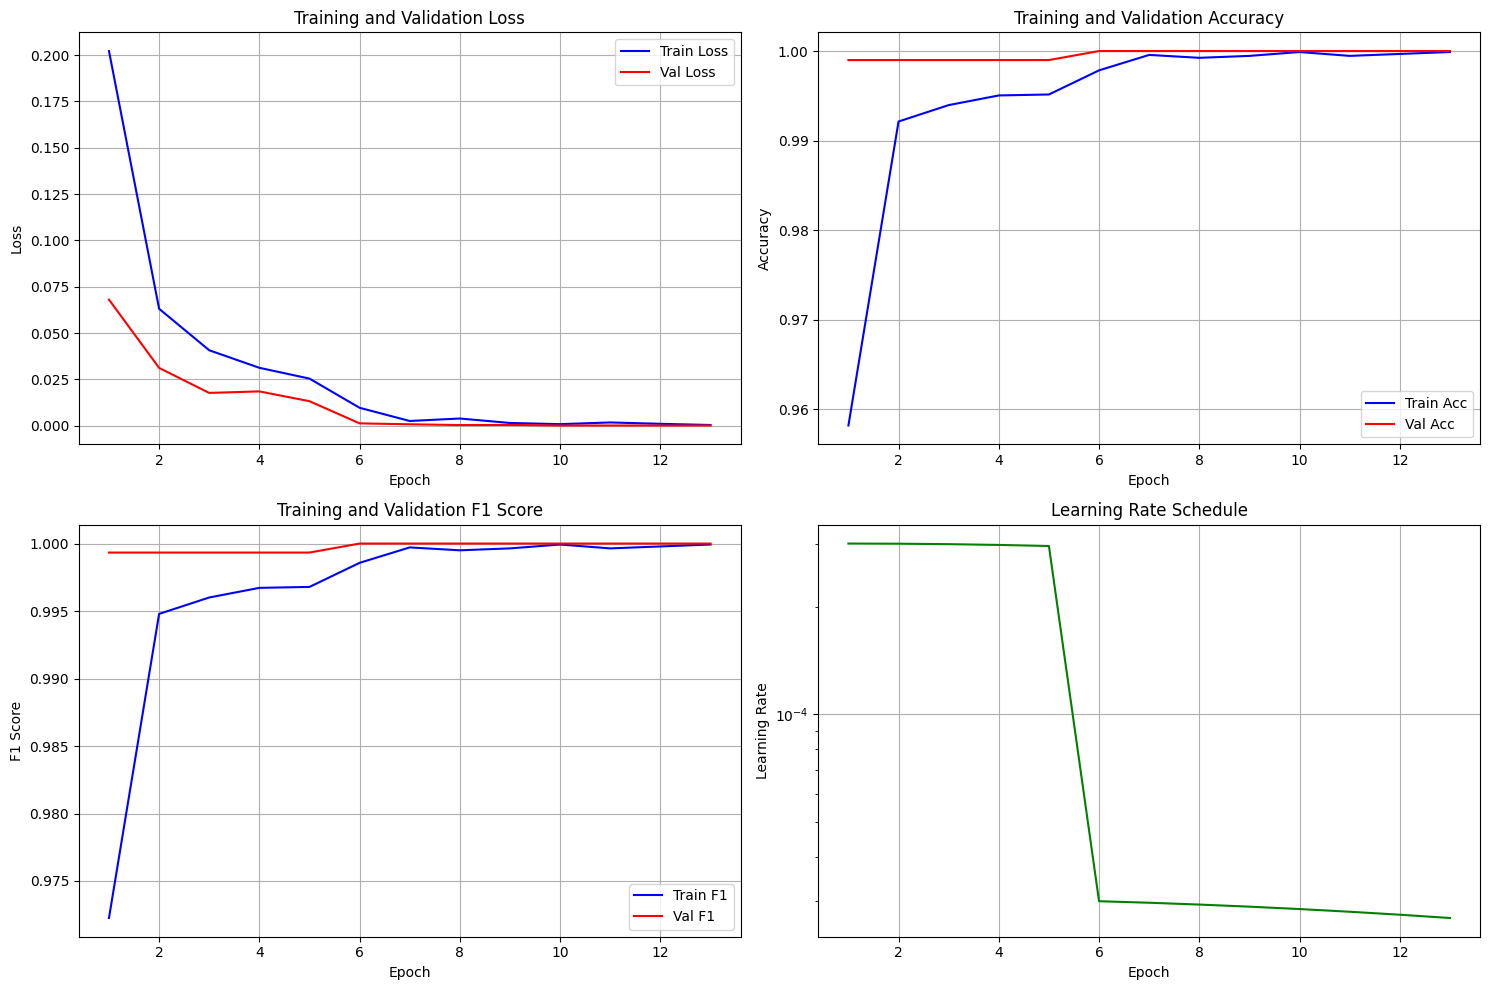


🧪 Evaluating on test set...
✓ Loaded best model from epoch 13
✓ Loaded best model from epoch 13


Testing: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s]




TEST SET RESULTS:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  AUC: 1.0000
  Loss: 0.0001

📊 Generating confusion matrix...


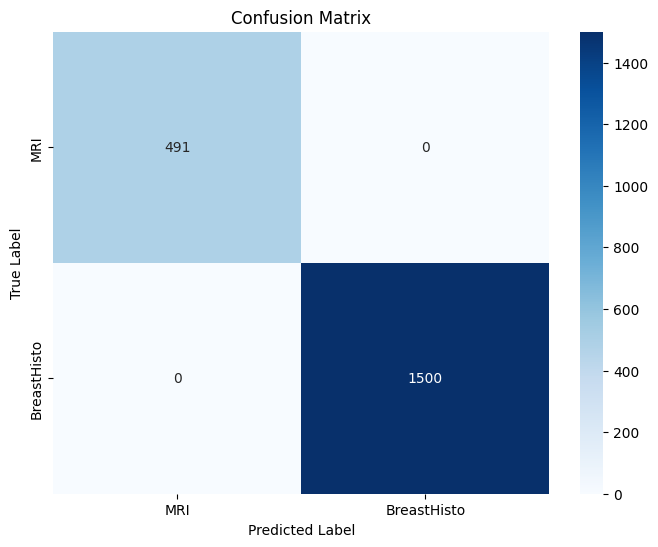


📈 Generating ROC curve...


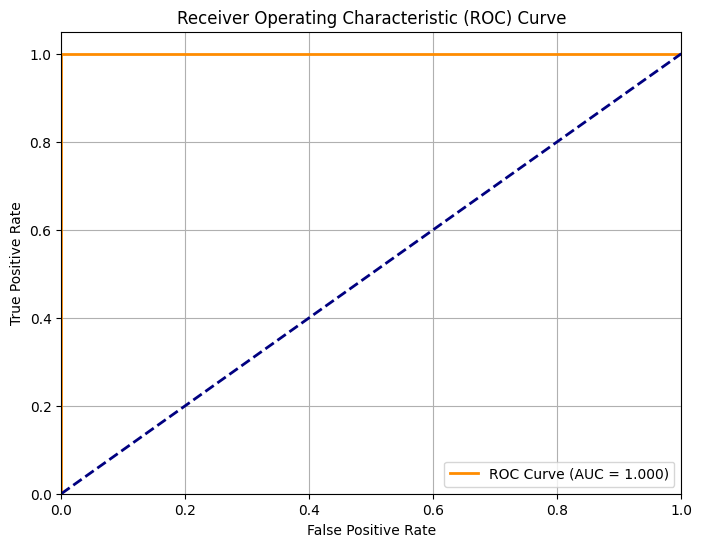


📋 Classification Report:
              precision    recall  f1-score   support

         MRI       1.00      1.00      1.00       491
 BreastHisto       1.00      1.00      1.00      1500

    accuracy                           1.00      1991
   macro avg       1.00      1.00      1.00      1991
weighted avg       1.00      1.00      1.00      1991


💾 Results saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain\outputs\final_results_efficientnet_b0.json

🎯 TARGET EVALUATION:
  Target accuracy: 95.0%
  Achieved accuracy: 100.0%
  Target achieved: ✅ YES


In [12]:
def plot_training_history(metrics_tracker, save_path=None):
    """Plot training history"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(metrics_tracker.metrics['train_loss']) + 1)
    
    # Loss plot
    axes[0, 0].plot(epochs, metrics_tracker.metrics['train_loss'], 'b-', label='Train Loss')
    axes[0, 0].plot(epochs, metrics_tracker.metrics['val_loss'], 'r-', label='Val Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy plot
    axes[0, 1].plot(epochs, metrics_tracker.metrics['train_acc'], 'b-', label='Train Acc')
    axes[0, 1].plot(epochs, metrics_tracker.metrics['val_acc'], 'r-', label='Val Acc')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # F1 Score plot
    axes[1, 0].plot(epochs, metrics_tracker.metrics['train_f1'], 'b-', label='Train F1')
    axes[1, 0].plot(epochs, metrics_tracker.metrics['val_f1'], 'r-', label='Val F1')
    axes[1, 0].set_title('Training and Validation F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rate plot
    axes[1, 1].plot(epochs, metrics_tracker.metrics['learning_rates'], 'g-')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def evaluate_test_set(model, test_loader, device):
    """Comprehensive evaluation on test set"""
    
    # Load best model
    best_model_path = models_dir / f"best_{CONFIG['model_name']}_binary.pth"
    if best_model_path.exists():
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")
    
    model.eval()
    
    all_labels = []
    all_predictions = []
    all_probabilities = []
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            all_labels.extend(labels.cpu())
            all_predictions.extend(predictions.cpu())
            all_probabilities.extend(probabilities.cpu())
    
    # Calculate metrics
    test_metrics = calculate_metrics(
        torch.tensor(all_labels),
        torch.tensor(all_predictions),
        torch.tensor(all_probabilities)
    )
    test_metrics['loss'] = test_loss / len(test_loader)
    
    return test_metrics, all_labels, all_predictions, all_probabilities

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Plot confusion matrix"""
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return cm

def plot_roc_curve(y_true, y_prob, save_path=None):
    """Plot ROC curve"""
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Generate visualizations and final evaluation
print("=" * 70)
print("FINAL EVALUATION AND VISUALIZATION")
print("=" * 70)

# Plot training history
if 'final_metrics' in locals():
    print("\n📈 Plotting training history...")
    plot_training_history(
        final_metrics, 
        save_path=outputs_dir / f"training_history_{CONFIG['model_name']}.png"
    )
    
    # Evaluate on test set
    print("\n🧪 Evaluating on test set...")
    test_metrics, test_labels, test_predictions, test_probabilities = evaluate_test_set(
        model, dataloaders['test'], device
    )
    
    print(f"\nTEST SET RESULTS:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  Recall: {test_metrics['recall']:.4f}")
    print(f"  F1 Score: {test_metrics['f1']:.4f}")
    print(f"  AUC: {test_metrics['auc']:.4f}")
    print(f"  Loss: {test_metrics['loss']:.4f}")
    
    # Plot confusion matrix
    print(f"\n📊 Generating confusion matrix...")
    cm = plot_confusion_matrix(
        test_labels, test_predictions, CLASS_NAMES,
        save_path=outputs_dir / f"confusion_matrix_{CONFIG['model_name']}.png"
    )
    
    # Plot ROC curve
    print(f"\n📈 Generating ROC curve...")
    plot_roc_curve(
        test_labels, test_probabilities,
        save_path=outputs_dir / f"roc_curve_{CONFIG['model_name']}.png"
    )
    
    # Generate detailed classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(test_labels, test_predictions, target_names=CLASS_NAMES))
    
    # Save final results
    results = {
        'model_name': CONFIG['model_name'],
        'training_config': CONFIG,
        'test_metrics': test_metrics,
        'best_validation_metrics': {
            'val_accuracy': final_metrics.get_best_metric('val_accuracy'),
            'val_f1': final_metrics.get_best_metric('val_f1'),
            'val_auc': final_metrics.get_best_metric('val_auc'),
            'best_epoch': final_metrics.best_metrics['best_epoch']
        },
        'timestamp': datetime.now().isoformat()
    }
    
    results_path = outputs_dir / f"final_results_{CONFIG['model_name']}.json"
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n💾 Results saved to: {results_path}")
    
    # Check if we achieved target accuracy
    target_accuracy = 0.95
    achieved_target = test_metrics['accuracy'] >= target_accuracy
    
    print(f"\n🎯 TARGET EVALUATION:")
    print(f"  Target accuracy: {target_accuracy:.1%}")
    print(f"  Achieved accuracy: {test_metrics['accuracy']:.1%}")
    print(f"  Target achieved: {'✅ YES' if achieved_target else '❌ NO'}")
    
else:
    print("⚠️  Training metrics not available for visualization")

## 12. Model Summary and Next Steps

In [13]:
print("=" * 70)
print("TRAINING COMPLETE - SUMMARY")
print("=" * 70)

# Print final summary
print(f"\n🏁 TRAINING SUMMARY:")
print(f"  Model: {CONFIG['model_name']}")
print(f"  Pretrained: {CONFIG['pretrained']}")
print(f"  Image size: {CONFIG['image_size']}x{CONFIG['image_size']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Total epochs: {CONFIG['epochs']}")

if 'final_metrics' in locals() and 'test_metrics' in locals():
    print(f"\n📊 BEST RESULTS:")
    print(f"  Validation Accuracy: {final_metrics.get_best_metric('val_accuracy'):.4f}")
    print(f"  Validation F1: {final_metrics.get_best_metric('val_f1'):.4f}")
    print(f"  Validation AUC: {final_metrics.get_best_metric('val_auc'):.4f}")
    
    print(f"\n🧪 TEST SET PERFORMANCE:")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Test F1: {test_metrics['f1']:.4f}")
    print(f"  Test AUC: {test_metrics['auc']:.4f}")
    
    target_met = test_metrics['accuracy'] >= 0.95
    print(f"\n🎯 TARGET ACHIEVEMENT:")
    print(f"  95% Accuracy Target: {'✅ ACHIEVED' if target_met else '❌ NOT ACHIEVED'}")
    print(f"  Actual Performance: {test_metrics['accuracy']:.1%}")

print(f"\n📁 SAVED ARTIFACTS:")
print(f"  Best model: models/best_{CONFIG['model_name']}_binary.pth")
print(f"  Training plots: outputs/training_history_{CONFIG['model_name']}.png")
print(f"  Confusion matrix: outputs/confusion_matrix_{CONFIG['model_name']}.png")
print(f"  ROC curve: outputs/roc_curve_{CONFIG['model_name']}.png")
print(f"  Final results: outputs/final_results_{CONFIG['model_name']}.json")

print(f"\n🚀 NEXT STEPS:")
print(f"  1. Experiment with other models (ResNet18, Custom CNN)")
print(f"  2. Hyperparameter tuning (learning rate, batch size, augmentations)")
print(f"  3. Cross-validation for robust evaluation")
print(f"  4. Error analysis on misclassified samples")
print(f"  5. Ensemble methods for improved performance")
print(f"  6. Deploy model for inference")

print(f"\n💡 OPTIMIZATION SUGGESTIONS:")
if 'test_metrics' in locals():
    if test_metrics['accuracy'] < 0.95:
        print(f"  - Try larger models (EfficientNet-B1/B2)")
        print(f"  - Increase training epochs with patience")
        print(f"  - Experiment with different augmentation strategies")
        print(f"  - Use ensemble of multiple models")
        print(f"  - Fine-tune with different learning rates")
    else:
        print(f"  - Model performance is excellent!")
        print(f"  - Consider model compression for deployment")
        print(f"  - Validate on additional test data")

print(f"\n" + "=" * 70)
print("BINARY CLASSIFICATION TRAINING COMPLETED!")
print("=" * 70)

TRAINING COMPLETE - SUMMARY

🏁 TRAINING SUMMARY:
  Model: efficientnet_b0
  Pretrained: True
  Image size: 224x224
  Batch size: 32
  Total epochs: 50

📊 BEST RESULTS:
  Validation Accuracy: 1.0000
  Validation F1: 1.0000
  Validation AUC: 1.0000

🧪 TEST SET PERFORMANCE:
  Test Accuracy: 1.0000
  Test F1: 1.0000
  Test AUC: 1.0000

🎯 TARGET ACHIEVEMENT:
  95% Accuracy Target: ✅ ACHIEVED
  Actual Performance: 100.0%

📁 SAVED ARTIFACTS:
  Best model: models/best_efficientnet_b0_binary.pth
  Training plots: outputs/training_history_efficientnet_b0.png
  Confusion matrix: outputs/confusion_matrix_efficientnet_b0.png
  ROC curve: outputs/roc_curve_efficientnet_b0.png
  Final results: outputs/final_results_efficientnet_b0.json

🚀 NEXT STEPS:
  1. Experiment with other models (ResNet18, Custom CNN)
  2. Hyperparameter tuning (learning rate, batch size, augmentations)
  3. Cross-validation for robust evaluation
  4. Error analysis on misclassified samples
  5. Ensemble methods for improved per

## 13. Comprehensive Evaluation & Reporting

This section provides detailed evaluation metrics, visualizations, and error analysis on the held-out test set following best practices for model evaluation and reproducibility.

In [14]:
# Comprehensive Test Set Evaluation
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve
)
import matplotlib.patches as mpatches

def comprehensive_evaluation(model, test_loader, device, class_names):
    """
    Comprehensive evaluation on test set with detailed metrics and visualizations
    """
    print("=" * 80)
    print("COMPREHENSIVE TEST SET EVALUATION")
    print("=" * 80)
    
    # Create reports directory
    reports_dir = project_root / 'reports'
    reports_dir.mkdir(exist_ok=True)
    
    # Load best model
    best_model_path = models_dir / f"best_{CONFIG['model_name']}_binary.pth"
    if best_model_path.exists():
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")
        best_epoch = checkpoint['epoch'] + 1
    else:
        print("⚠️  Best model not found, using current model state")
        best_epoch = "Unknown"
    
    model.eval()
    
    # Collect predictions and true labels
    all_labels = []
    all_predictions = []
    all_probabilities = []
    all_image_paths = []
    test_loss = 0.0
    
    print("\n🔍 Running inference on test set...")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Testing")):
            images, labels = images.to(device), labels.to(device)
            
            # Get image paths for this batch (for error analysis)
            start_idx = batch_idx * test_loader.batch_size
            end_idx = start_idx + len(labels)
            batch_paths = [test_loader.dataset.samples[i][0] for i in range(start_idx, min(end_idx, len(test_loader.dataset)))]
            
            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions and probabilities
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            # Store results
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_image_paths.extend(batch_paths)
    
    # Convert to numpy arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)
    
    print(f"✓ Inference completed on {len(y_true)} test samples")
    
    return y_true, y_pred, y_prob, all_image_paths, test_loss / len(test_loader), best_epoch

def calculate_detailed_metrics(y_true, y_pred, y_prob, class_names):
    """Calculate comprehensive metrics including macro and per-class statistics"""
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics (binary classification)
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Macro-averaged metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Weighted metrics (account for class imbalance)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # ROC-AUC and PR-AUC
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)
    except ValueError:
        roc_auc = 0.0
        pr_auc = 0.0
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # True negatives, false positives, false negatives, true positives
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Sensitivity (True Positive Rate / Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    metrics = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'specificity': specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm.tolist(),
        'per_class_metrics': {
            class_names[i]: {
                'precision': precision_per_class[i],
                'recall': recall_per_class[i],
                'f1': f1_per_class[i],
                'support': int(support_per_class[i])
            } for i in range(len(class_names))
        },
        'raw_counts': {
            'true_negatives': int(tn),
            'false_positives': int(fp),
            'false_negatives': int(fn),
            'true_positives': int(tp)
        }
    }
    
    return metrics

# Run comprehensive evaluation
if 'model' in locals() and 'dataloaders' in locals():
    print("Starting comprehensive evaluation...")
    
    y_true, y_pred, y_prob, image_paths, test_loss, best_epoch = comprehensive_evaluation(
        model, dataloaders['test'], device, CLASS_NAMES
    )
    
    # Calculate detailed metrics
    detailed_metrics = calculate_detailed_metrics(y_true, y_pred, y_prob, CLASS_NAMES)
    
    print("\n" + "=" * 60)
    print("DETAILED TEST SET METRICS")
    print("=" * 60)
    
    print(f"\n📊 OVERALL PERFORMANCE:")
    print(f"  Accuracy: {detailed_metrics['accuracy']:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    
    print(f"\n📈 MACRO-AVERAGED METRICS:")
    print(f"  Precision: {detailed_metrics['precision_macro']:.4f}")
    print(f"  Recall: {detailed_metrics['recall_macro']:.4f}")
    print(f"  F1-Score: {detailed_metrics['f1_macro']:.4f}")
    
    print(f"\n⚖️  WEIGHTED METRICS (Class-Balanced):")
    print(f"  Precision: {detailed_metrics['precision_weighted']:.4f}")
    print(f"  Recall: {detailed_metrics['recall_weighted']:.4f}")
    print(f"  F1-Score: {detailed_metrics['f1_weighted']:.4f}")
    
    print(f"\n📋 PER-CLASS METRICS:")
    for class_name, metrics in detailed_metrics['per_class_metrics'].items():
        print(f"  {class_name}:")
        print(f"    Precision: {metrics['precision']:.4f}")
        print(f"    Recall: {metrics['recall']:.4f}")
        print(f"    F1-Score: {metrics['f1']:.4f}")
        print(f"    Support: {metrics['support']} samples")
    
    print(f"\n🎯 ADDITIONAL METRICS:")
    print(f"  ROC-AUC: {detailed_metrics['roc_auc']:.4f}")
    print(f"  PR-AUC: {detailed_metrics['pr_auc']:.4f}")
    print(f"  Sensitivity (Recall): {detailed_metrics['sensitivity']:.4f}")
    print(f"  Specificity: {detailed_metrics['specificity']:.4f}")
    
    print(f"\n🔢 CONFUSION MATRIX COUNTS:")
    print(f"  True Negatives: {detailed_metrics['raw_counts']['true_negatives']}")
    print(f"  False Positives: {detailed_metrics['raw_counts']['false_positives']}")
    print(f"  False Negatives: {detailed_metrics['raw_counts']['false_negatives']}")
    print(f"  True Positives: {detailed_metrics['raw_counts']['true_positives']}")
    
else:
    print("⚠️  Model or data loaders not available for evaluation")

Starting comprehensive evaluation...
COMPREHENSIVE TEST SET EVALUATION
✓ Loaded best model from epoch 13

🔍 Running inference on test set...


Testing: 100%|██████████| 63/63 [00:06<00:00,  9.74it/s]

✓ Inference completed on 1991 test samples

DETAILED TEST SET METRICS

📊 OVERALL PERFORMANCE:
  Accuracy: 1.0000
  Test Loss: 0.0001

📈 MACRO-AVERAGED METRICS:
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

⚖️  WEIGHTED METRICS (Class-Balanced):
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

📋 PER-CLASS METRICS:
  MRI:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 491 samples
  BreastHisto:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 1500 samples

🎯 ADDITIONAL METRICS:
  ROC-AUC: 1.0000
  PR-AUC: 1.0000
  Sensitivity (Recall): 1.0000
  Specificity: 1.0000

🔢 CONFUSION MATRIX COUNTS:
  True Negatives: 491
  False Positives: 0
  False Negatives: 0
  True Positives: 1500



GENERATING DETAILED VISUALIZATIONS

📊 Generating detailed confusion matrix...
✓ Confusion matrix saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain\reports\confusion_matrix_detailed_efficientnet_b0.png


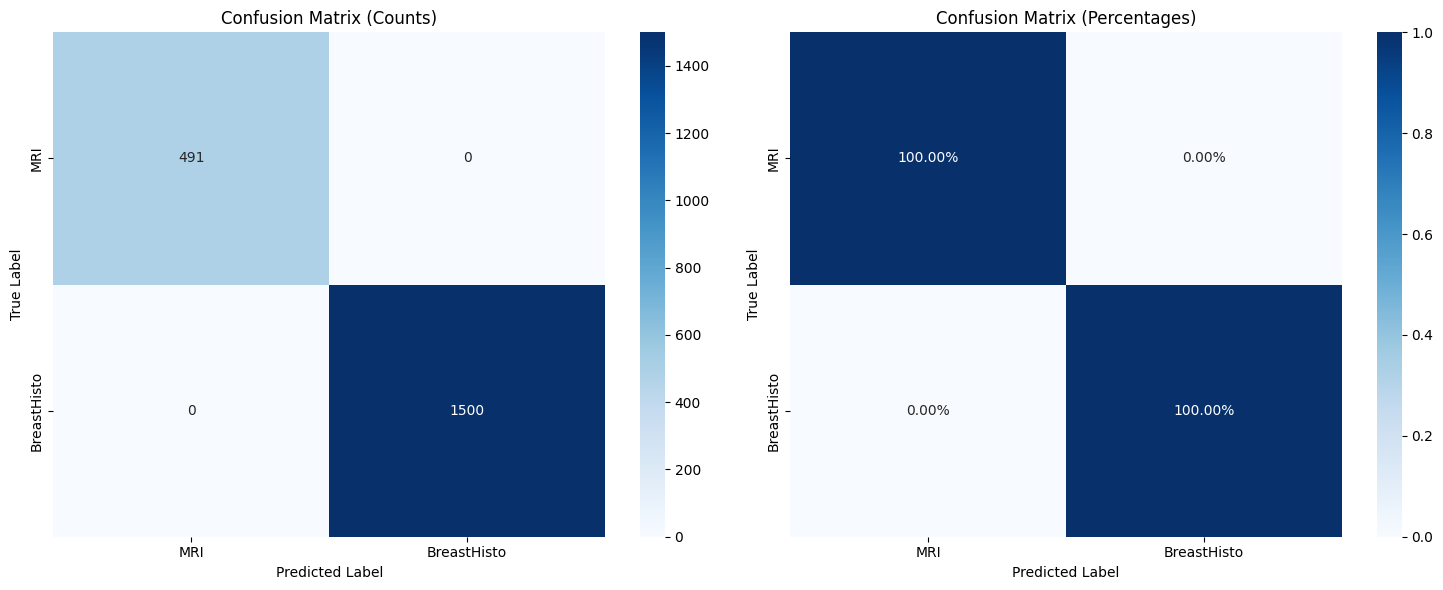


📈 Generating ROC and Precision-Recall curves...
✓ ROC and PR curves saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain\reports\roc_pr_curves_efficientnet_b0.png


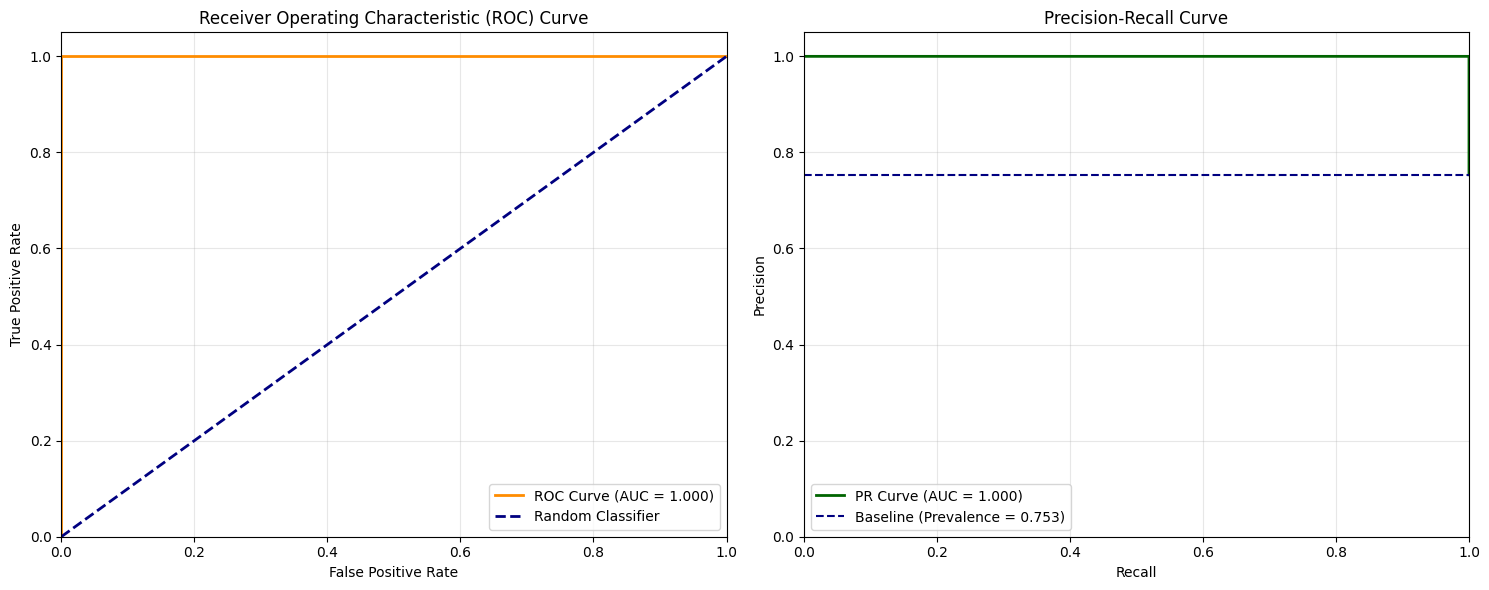

In [15]:
# Visualization Functions
def plot_detailed_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Plot detailed confusion matrix with percentages and counts"""
    
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    return cm

def plot_roc_and_pr_curves(y_true, y_prob, save_path=None):
    """Plot ROC and Precision-Recall curves"""
    
    # Calculate curves
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.axhline(y=np.mean(y_true), color='navy', linestyle='--', 
                label=f'Baseline (Prevalence = {np.mean(y_true):.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ ROC and PR curves saved to: {save_path}")
    
    plt.show()
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'roc_thresholds': roc_thresholds.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'pr_thresholds': pr_thresholds.tolist()
    }

# Generate detailed visualizations
if 'y_true' in locals():
    print("\n" + "=" * 60)
    print("GENERATING DETAILED VISUALIZATIONS")
    print("=" * 60)
    
    reports_dir = project_root / 'reports'
    reports_dir.mkdir(exist_ok=True)
    
    # 1. Detailed Confusion Matrix
    print("\n📊 Generating detailed confusion matrix...")
    cm = plot_detailed_confusion_matrix(
        y_true, y_pred, CLASS_NAMES,
        save_path=reports_dir / f"confusion_matrix_detailed_{CONFIG['model_name']}.png"
    )
    
    # 2. ROC and PR Curves
    print("\n📈 Generating ROC and Precision-Recall curves...")
    curve_data = plot_roc_and_pr_curves(
        y_true, y_prob,
        save_path=reports_dir / f"roc_pr_curves_{CONFIG['model_name']}.png"
    )
    
else:
    print("⚠️  Evaluation results not available for visualization")

In [16]:
# Error Analysis and Sample Visualization
def analyze_errors(y_true, y_pred, y_prob, image_paths, class_names, top_n=5):
    """Analyze false positives and false negatives"""
    
    print("\n" + "=" * 60)
    print("ERROR ANALYSIS")
    print("=" * 60)
    
    # Create error analysis DataFrame
    error_df = pd.DataFrame({
        'image_path': image_paths,
        'true_label': y_true,
        'pred_label': y_pred,
        'probability': y_prob,
        'true_class': [class_names[int(label)] for label in y_true],
        'pred_class': [class_names[int(label)] for label in y_pred]
    })
    
    # Add error columns
    error_df['correct'] = error_df['true_label'] == error_df['pred_label']
    error_df['confidence'] = np.maximum(error_df['probability'], 1 - error_df['probability'])
    
    # False Positives (predicted 1, actually 0)
    false_positives = error_df[(error_df['true_label'] == 0) & (error_df['pred_label'] == 1)]
    false_positives = false_positives.sort_values('probability', ascending=False)
    
    # False Negatives (predicted 0, actually 1)
    false_negatives = error_df[(error_df['true_label'] == 1) & (error_df['pred_label'] == 0)]
    false_negatives = false_negatives.sort_values('probability', ascending=True)
    
    # True Positives (high confidence correct predictions of class 1)
    true_positives = error_df[(error_df['true_label'] == 1) & (error_df['pred_label'] == 1)]
    true_positives = true_positives.sort_values('probability', ascending=False)
    
    # True Negatives (high confidence correct predictions of class 0)
    true_negatives = error_df[(error_df['true_label'] == 0) & (error_df['pred_label'] == 0)]
    true_negatives = true_negatives.sort_values('probability', ascending=True)
    
    print(f"\n📊 ERROR SUMMARY:")
    print(f"  Total samples: {len(error_df)}")
    print(f"  Correct predictions: {len(error_df[error_df['correct']])}")
    print(f"  Incorrect predictions: {len(error_df[~error_df['correct']])}")
    print(f"  False Positives: {len(false_positives)}")
    print(f"  False Negatives: {len(false_negatives)}")
    
    if len(false_positives) > 0:
        print(f"\n❌ TOP {min(top_n, len(false_positives))} FALSE POSITIVES:")
        print(f"   (Predicted {class_names[1]}, Actually {class_names[0]})")
        for i, (_, row) in enumerate(false_positives.head(top_n).iterrows()):
            print(f"   {i+1}. Confidence: {row['probability']:.3f} | {Path(row['image_path']).name}")
    
    if len(false_negatives) > 0:
        print(f"\n❌ TOP {min(top_n, len(false_negatives))} FALSE NEGATIVES:")
        print(f"   (Predicted {class_names[0]}, Actually {class_names[1]})")
        for i, (_, row) in enumerate(false_negatives.head(top_n).iterrows()):
            print(f"   {i+1}. Confidence: {1-row['probability']:.3f} | {Path(row['image_path']).name}")
    
    return {
        'error_df': error_df,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_positives': true_positives,
        'true_negatives': true_negatives
    }

def visualize_error_samples(error_data, sample_type='false_positives', n_samples=6, figsize=(15, 10)):
    """Visualize error samples"""
    
    if sample_type not in error_data:
        print(f"⚠️  {sample_type} not found in error data")
        return
    
    samples_df = error_data[sample_type].head(n_samples)
    
    if len(samples_df) == 0:
        print(f"✅ No {sample_type} found!")
        return
    
    print(f"\n🖼️  Visualizing top {len(samples_df)} {sample_type}...")
    
    # Calculate grid dimensions
    cols = min(3, len(samples_df))
    rows = (len(samples_df) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (_, row) in enumerate(samples_df.iterrows()):
        if i >= len(axes):
            break
            
        # Load and display image
        try:
            img = Image.open(row['image_path'])
            axes[i].imshow(img)
            axes[i].axis('off')
            
            # Create title with error information
            title = f"True: {row['true_class']}\nPred: {row['pred_class']}\nConf: {row['probability']:.3f}"
            axes[i].set_title(title, fontsize=10)
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{Path(row['image_path']).name}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Conf: {row['probability']:.3f}")
    
    # Hide extra subplots
    for i in range(len(samples_df), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"Top {sample_type.replace('_', ' ').title()}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run error analysis
if 'y_true' in locals():
    error_analysis = analyze_errors(y_true, y_pred, y_prob, image_paths, CLASS_NAMES, top_n=5)
    
    # Visualize error samples (you can run these individually)
    print("\n" + "=" * 60)
    print("SAMPLE VISUALIZATIONS")
    print("=" * 60)
    print("Note: Run the visualization functions below to see sample images")
    
    # Store visualization commands for user to run
    viz_commands = [
        "# Visualize False Positives",
        "visualize_error_samples(error_analysis, 'false_positives', n_samples=6)",
        "",
        "# Visualize False Negatives", 
        "visualize_error_samples(error_analysis, 'false_negatives', n_samples=6)",
        "",
        "# Visualize High-Confidence True Positives",
        "visualize_error_samples(error_analysis, 'true_positives', n_samples=6)",
        "",
        "# Visualize High-Confidence True Negatives",
        "visualize_error_samples(error_analysis, 'true_negatives', n_samples=6)"
    ]
    
    print("\n📋 Available visualization commands:")
    for cmd in viz_commands:
        if cmd.startswith("#"):
            print(f"\n{cmd}")
        elif cmd:
            print(f"   {cmd}")
    
else:
    print("⚠️  Evaluation results not available for error analysis")


ERROR ANALYSIS

📊 ERROR SUMMARY:
  Total samples: 1991
  Correct predictions: 1991
  Incorrect predictions: 0
  False Positives: 0
  False Negatives: 0

SAMPLE VISUALIZATIONS
Note: Run the visualization functions below to see sample images

📋 Available visualization commands:

# Visualize False Positives
   visualize_error_samples(error_analysis, 'false_positives', n_samples=6)

# Visualize False Negatives
   visualize_error_samples(error_analysis, 'false_negatives', n_samples=6)

# Visualize High-Confidence True Positives
   visualize_error_samples(error_analysis, 'true_positives', n_samples=6)

# Visualize High-Confidence True Negatives
   visualize_error_samples(error_analysis, 'true_negatives', n_samples=6)


In [17]:
# Dataset Documentation and Final Report Generation
def document_dataset_splits():
    """Document exact data counts per split and per class for reproducibility"""
    
    print("\n" + "=" * 60)
    print("DATASET DOCUMENTATION")
    print("=" * 60)
    
    # Collect detailed dataset statistics
    dataset_documentation = {
        'metadata': {
            'creation_date': datetime.now().isoformat(),
            'model_name': CONFIG['model_name'],
            'image_size': CONFIG['image_size'],
            'preprocessing': 'ImageNet normalization, 3-channel conversion',
            'class_names': CLASS_NAMES,
            'class_mapping': CLASS_TO_IDX
        },
        'splits': {}
    }
    
    total_images = 0
    splits = ['train', 'val', 'test']
    
    print(f"\n📁 DATASET SPLITS DOCUMENTATION:")
    
    for split in splits:
        split_dir = processed_data_dir / split
        split_info = {
            'classes': {},
            'total': 0,
            'path': str(split_dir)
        }
        
        print(f"\n{split.upper()} SET:")
        
        for class_name in CLASS_NAMES:
            class_dir = split_dir / class_name
            
            if class_dir.exists():
                # Count all image files
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tiff', '*.tif', '*.bmp']
                image_files = []
                for ext in image_extensions:
                    image_files.extend(list(class_dir.glob(ext)))
                
                count = len(image_files)
                split_info['classes'][class_name] = {
                    'count': count,
                    'path': str(class_dir),
                    'percentage': 0  # Will calculate after total
                }
                split_info['total'] += count
                total_images += count
                
                print(f"  {class_name}: {count:,} images")
            else:
                print(f"  {class_name}: Directory not found - {class_dir}")
                split_info['classes'][class_name] = {
                    'count': 0,
                    'path': str(class_dir),
                    'percentage': 0
                }
        
        # Calculate percentages within split
        for class_name in CLASS_NAMES:
            if split_info['total'] > 0:
                split_info['classes'][class_name]['percentage'] = \
                    (split_info['classes'][class_name]['count'] / split_info['total']) * 100
        
        dataset_documentation['splits'][split] = split_info
        print(f"  Total {split}: {split_info['total']:,} images")
        
        # Show class distribution
        for class_name in CLASS_NAMES:
            percentage = split_info['classes'][class_name]['percentage']
            print(f"    {class_name}: {percentage:.1f}%")
    
    # Calculate overall statistics
    dataset_documentation['metadata']['total_images'] = total_images
    
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"  Total images across all splits: {total_images:,}")
    
    # Calculate split percentages
    for split in splits:
        split_total = dataset_documentation['splits'][split]['total']
        split_percentage = (split_total / total_images * 100) if total_images > 0 else 0
        dataset_documentation['splits'][split]['split_percentage'] = split_percentage
        print(f"  {split}: {split_total:,} images ({split_percentage:.1f}%)")
    
    # Overall class distribution
    print(f"\n📈 OVERALL CLASS DISTRIBUTION:")
    overall_class_counts = {}
    for class_name in CLASS_NAMES:
        total_class_count = sum(
            dataset_documentation['splits'][split]['classes'][class_name]['count'] 
            for split in splits
        )
        overall_class_counts[class_name] = total_class_count
        percentage = (total_class_count / total_images * 100) if total_images > 0 else 0
        print(f"  {class_name}: {total_class_count:,} images ({percentage:.1f}%)")
    
    dataset_documentation['metadata']['overall_class_distribution'] = overall_class_counts
    
    return dataset_documentation

def generate_final_report(detailed_metrics, curve_data, dataset_doc, error_analysis, best_epoch):
    """Generate comprehensive final report with all metrics and documentation"""
    
    print("\n" + "=" * 60)
    print("GENERATING FINAL REPORT")
    print("=" * 60)
    
    # Create comprehensive report
    final_report = {
        'experiment_info': {
            'timestamp': datetime.now().isoformat(),
            'model_name': CONFIG['model_name'],
            'best_epoch': best_epoch,
            'training_config': CONFIG,
            'target_accuracy': 0.95,
            'target_achieved': detailed_metrics['accuracy'] >= 0.95
        },
        'dataset_documentation': dataset_doc,
        'test_metrics': {
            **detailed_metrics,
            'test_loss': test_loss,
            'curve_metrics': {
                'roc_auc': curve_data['roc_auc'],
                'pr_auc': curve_data['pr_auc']
            }
        },
        'error_analysis_summary': {
            'total_samples': len(error_analysis['error_df']),
            'correct_predictions': len(error_analysis['error_df'][error_analysis['error_df']['correct']]),
            'false_positives_count': len(error_analysis['false_positives']),
            'false_negatives_count': len(error_analysis['false_negatives']),
            'top_false_positives': error_analysis['false_positives'].head(5)[['image_path', 'probability', 'true_class', 'pred_class']].to_dict('records'),
            'top_false_negatives': error_analysis['false_negatives'].head(5)[['image_path', 'probability', 'true_class', 'pred_class']].to_dict('records')
        }
    }
    
    # Save JSON report
    reports_dir = project_root / 'reports'
    reports_dir.mkdir(exist_ok=True)
    
    json_path = reports_dir / f"final_report_{CONFIG['model_name']}.json"
    with open(json_path, 'w') as f:
        json.dump(final_report, f, indent=2, default=str)
    print(f"✓ JSON report saved to: {json_path}")
    
    # Save CSV summary
    csv_data = {
        'Metric': [],
        'Value': []
    }
    
    # Add key metrics to CSV
    key_metrics = [
        ('Accuracy', detailed_metrics['accuracy']),
        ('Precision (Macro)', detailed_metrics['precision_macro']),
        ('Recall (Macro)', detailed_metrics['recall_macro']),
        ('F1-Score (Macro)', detailed_metrics['f1_macro']),
        ('Precision (Weighted)', detailed_metrics['precision_weighted']),
        ('Recall (Weighted)', detailed_metrics['recall_weighted']),
        ('F1-Score (Weighted)', detailed_metrics['f1_weighted']),
        ('ROC-AUC', detailed_metrics['roc_auc']),
        ('PR-AUC', detailed_metrics['pr_auc']),
        ('Specificity', detailed_metrics['specificity']),
        ('Sensitivity', detailed_metrics['sensitivity']),
        ('Test Loss', test_loss),
        ('Target Achieved (95%)', 'Yes' if detailed_metrics['accuracy'] >= 0.95 else 'No')
    ]
    
    for metric_name, value in key_metrics:
        csv_data['Metric'].append(metric_name)
        csv_data['Value'].append(value)
    
    # Add per-class metrics
    for class_name, metrics in detailed_metrics['per_class_metrics'].items():
        for metric_type, value in metrics.items():
            if metric_type != 'support':
                csv_data['Metric'].append(f"{class_name}_{metric_type}")
                csv_data['Value'].append(value)
    
    csv_df = pd.DataFrame(csv_data)
    csv_path = reports_dir / f"metrics_summary_{CONFIG['model_name']}.csv"
    csv_df.to_csv(csv_path, index=False)
    print(f"✓ CSV metrics saved to: {csv_path}")
    
    # Save detailed error analysis CSV
    error_df_path = reports_dir / f"error_analysis_{CONFIG['model_name']}.csv"
    error_analysis['error_df'].to_csv(error_df_path, index=False)
    print(f"✓ Error analysis CSV saved to: {error_df_path}")
    
    # Print final summary
    print(f"\n" + "=" * 70)
    print("FINAL EVALUATION SUMMARY")
    print("=" * 70)
    
    print(f"\n🎯 TARGET ACHIEVEMENT:")
    target_achieved = detailed_metrics['accuracy'] >= 0.95
    print(f"  95% Accuracy Target: {'✅ ACHIEVED' if target_achieved else '❌ NOT ACHIEVED'}")
    print(f"  Actual Test Accuracy: {detailed_metrics['accuracy']:.1%}")
    
    print(f"\n📊 KEY METRICS:")
    print(f"  Accuracy: {detailed_metrics['accuracy']:.4f}")
    print(f"  F1-Score (Macro): {detailed_metrics['f1_macro']:.4f}")
    print(f"  ROC-AUC: {detailed_metrics['roc_auc']:.4f}")
    print(f"  Precision (Macro): {detailed_metrics['precision_macro']:.4f}")
    print(f"  Recall (Macro): {detailed_metrics['recall_macro']:.4f}")
    
    print(f"\n📁 GENERATED ARTIFACTS:")
    print(f"  📊 Confusion Matrix: reports/confusion_matrix_detailed_{CONFIG['model_name']}.png")
    print(f"  📈 ROC & PR Curves: reports/roc_pr_curves_{CONFIG['model_name']}.png")
    print(f"  📋 JSON Report: reports/final_report_{CONFIG['model_name']}.json")
    print(f"  📄 CSV Metrics: reports/metrics_summary_{CONFIG['model_name']}.csv")
    print(f"  🔍 Error Analysis: reports/error_analysis_{CONFIG['model_name']}.csv")
    print(f"  💾 Best Model: models/best_{CONFIG['model_name']}_binary.pth")
    
    return final_report

# Generate documentation and final report
if 'detailed_metrics' in locals():
    print("Generating comprehensive documentation and final report...")
    
    # Document dataset splits
    dataset_doc = document_dataset_splits()
    
    # Generate final comprehensive report
    final_report = generate_final_report(
        detailed_metrics, 
        curve_data, 
        dataset_doc, 
        error_analysis, 
        best_epoch
    )
    
    print(f"\n✅ Comprehensive evaluation and reporting completed!")
    print(f"📂 All artifacts saved to: {project_root / 'reports'}")
    
else:
    print("⚠️  Please run the evaluation cells first to generate the final report")

Generating comprehensive documentation and final report...

DATASET DOCUMENTATION

📁 DATASET SPLITS DOCUMENTATION:

TRAIN SET:
  MRI: 2,284 images
  BreastHisto: 7,000 images
  Total train: 9,284 images
    MRI: 24.6%
    BreastHisto: 75.4%

VAL SET:
  MRI: 489 images
  BreastHisto: 1,500 images
  Total val: 1,989 images
    MRI: 24.6%
    BreastHisto: 75.4%

TEST SET:
  MRI: 491 images
  BreastHisto: 1,500 images
  Total test: 1,991 images
    MRI: 24.7%
    BreastHisto: 75.3%

📊 OVERALL STATISTICS:
  Total images across all splits: 13,264
  train: 9,284 images (70.0%)
  val: 1,989 images (15.0%)
  test: 1,991 images (15.0%)

📈 OVERALL CLASS DISTRIBUTION:
  MRI: 3,264 images (24.6%)
  BreastHisto: 10,000 images (75.4%)

GENERATING FINAL REPORT
✓ JSON report saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain\reports\final_report_efficientnet_b0.json
✓ CSV metrics saved to: c:\Users\Ammad\Documents\Projects\Personal\Brain\reports\metrics_summary_efficientnet_b0.csv
✓ Error analy